In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
import pandas as pd
import numpy as np
data=pd.read_csv('/content/india-news-headlines.csv')
headlines=data.copy()
headlines.head(3)

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?


In [4]:
data2=pd.read_csv('/content/AAPL.csv')
price=data2.copy()
price.head(3)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-27,162.449997,163.839996,158.279999,159.220001,158.301254,121954600
1,2022-01-28,165.710007,170.350006,162.800003,170.330002,169.347153,179935700
2,2022-01-31,170.160004,175.000000,169.509995,174.779999,173.771469,115541600


In [ ]:
len(price), len(headlines)

(251, 105693)

In [ ]:
#check for null values
price.isnull().sum() #price.isna().any()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
 headlines.isnull().sum()

publish_date         0
headline_category    1
headline_text        3
dtype: int64

In [ ]:
#drop rows which have na values
headlines.dropna(subset=['headline_category','headline_text'],inplace=True)
headlines.isna().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [ ]:
#remove duplicates
headlines.drop_duplicates(inplace=True)
price.drop_duplicates(inplace=True)

Price data

In [ ]:
price.Date=pd.to_datetime(price['Date']).dt.normalize()
#price.head(2)
#price.set_index("Date",inplace=True)
#filtering the important columns
price = price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

#set date colums as index
price.set_index('Date', inplace= True)
price = price.sort_index(ascending=True, axis=0)
price.head(2)

,Close,Open,High,Low,Volume
Date,,,,,
2022-01-27,159.220001,162.449997,163.839996,158.279999,121954600
2022-01-28,170.330002,165.710007,170.350006,162.800003,179935700


Headline dataset

In [ ]:
headlines['publish_date'] = headlines['publish_date'].astype(str)
headlines['publish_date'] = headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
headlines['publish_date'] = pd.to_datetime(headlines['publish_date']).dt.normalize()
#headlines.head(2)

In [ ]:
headlines = headlines.filter(['publish_date', 'headline_text'])
headlines = headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
headlines = headlines.sort_index(ascending=True, axis=0)
headlines[0:5]

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...


In [23]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([price, headlines], axis=1)
stock_data=stock_data.drop('headline_category',axis=1)
# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)
stock_data[50:60]

,Date,Open,High,Low,Close,Adj Close,Volume,publish_date,headline_text
50,2022-04-08,171.779999,171.779999,169.199997,170.089996,169.323990,76575500.0,20010102,Moves afoot to evict squatters in Urban dist
51,2022-04-11,168.710007,169.029999,165.500000,165.750000,165.003525,72246700.0,20010102,Mafia calls the shots in Gandhinagar too
52,2022-04-12,168.020004,169.869995,166.639999,167.660004,166.904938,79265200.0,20010102,Come to Nandi Hills...and you can fly
53,2022-04-13,167.389999,171.039993,166.770004,170.399994,169.632584,70618900.0,20010102,HAL approached for super jumbo project
54,2022-04-14,170.619995,171.270004,165.039993,165.289993,164.545593,75329400.0,20010102,Nagathihalli returns with Preethiya Hudugi
55,2022-04-18,163.919998,166.600006,163.570007,165.070007,164.326599,69023900.0,20010102,Fashion in the future
56,2022-04-19,165.020004,167.820007,163.910004,167.399994,166.646088,67723800.0,20010102,Promises to keep
57,2022-04-20,168.759995,168.880005,166.100006,167.229996,166.476868,67929800.0,20010102,Home is where the holistic science is
58,2022-04-21,168.910004,171.529999,165.910004,166.419998,165.670517,87227800.0,20010102,A noisy effort to spruce up Commercial Street
59,2022-04-22,166.460007,167.869995,161.500000,161.789993,161.061340,84882400.0,20010102,The best music of the year


In [18]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,publish_date,headline_text,compound,negative,neutral,positive
0,2022-01-27,162.449997,163.839996,158.279999,159.220001,158.301254,121954600.0,20010102,Status quo will not be disturbed at Ayodhya; s...,,,,
1,2022-01-28,165.710007,170.350006,162.800003,170.330002,169.347153,179935700.0,20010102,Fissures in Hurriyat over Pak visit,,,,
2,2022-01-31,170.160004,175.000000,169.509995,174.779999,173.771469,115541600.0,20010102,America's unwanted heading for India?,,,,
3,2022-02-01,174.009995,174.839996,172.309998,174.610001,173.602463,86213900.0,20010102,For bigwigs; it is destination Goa,,,,
4,2022-02-02,174.750000,175.880005,173.330002,175.839996,174.825363,84914300.0,20010102,Extra buses to clear tourist traffic,,,,


In [15]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [24]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,publish_date,headline_text,compound,negative,neutral,positive
0,2022-01-27,162.449997,163.839996,158.279999,159.220001,158.301254,121954600.0,20010102,Status quo will not be disturbed at Ayodhya; s...,0.2924,0.000,0.805,0.195
1,2022-01-28,165.710007,170.350006,162.800003,170.330002,169.347153,179935700.0,20010102,Fissures in Hurriyat over Pak visit,0.0000,0.000,1.000,0.000
2,2022-01-31,170.160004,175.000000,169.509995,174.779999,173.771469,115541600.0,20010102,America's unwanted heading for India?,-0.2263,0.322,0.678,0.000
3,2022-02-01,174.009995,174.839996,172.309998,174.610001,173.602463,86213900.0,20010102,For bigwigs; it is destination Goa,0.0000,0.000,1.000,0.000
4,2022-02-02,174.750000,175.880005,173.330002,175.839996,174.825363,84914300.0,20010102,Extra buses to clear tourist traffic,0.3818,0.000,0.658,0.342


In [25]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

#saving csv file of final data
stock_data.to_csv('stock_data.csv')
# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
0,159.220001,0.2924,0.000,0.805,0.195,162.449997,163.839996,158.279999,121954600.0
1,170.330002,0.0000,0.000,1.000,0.000,165.710007,170.350006,162.800003,179935700.0
2,174.779999,-0.2263,0.322,0.678,0.000,170.160004,175.000000,169.509995,115541600.0
3,174.610001,0.0000,0.000,1.000,0.000,174.009995,174.839996,172.309998,86213900.0
4,175.839996,0.3818,0.000,0.658,0.342,174.750000,175.880005,173.330002,84914300.0


EDA for final stock data

Text(0, 0.5, 'Close Price ($)')

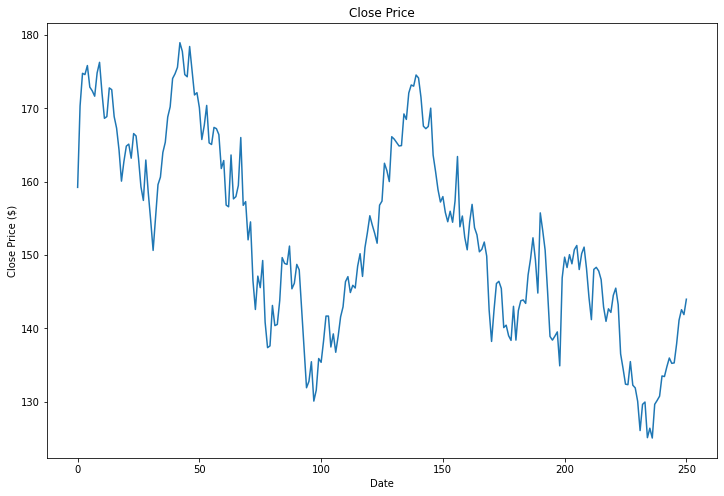

In [26]:
# setting figure size
plt.figure(figsize=(12,8))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [28]:
# calculating weekly rolling mean
stock_data.rolling(7).mean().head(15)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,171.438570,0.063986,0.046000,0.877286,0.076714,170.462856,172.892859,168.432855,1.086348e+08
7,173.215714,0.022214,0.046000,0.905143,0.048857,171.949999,174.337145,170.242855,1.022486e+08
8,173.858571,0.082429,0.087857,0.811571,0.100571,172.809998,175.051431,171.475710,8.723339e+07
9,174.072856,0.114757,0.041857,0.857571,0.100571,173.651426,175.287144,172.245710,8.091101e+07


In [29]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 200
Number of records in Test Data: 51


In [31]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


1      170.330002
2      174.779999
3      174.610001
4      175.839996
5      172.899994
          ...    
246    137.869995
247    141.110001
248    142.529999
249    141.860001
250    143.960007
Name: Close, Length: 250, dtype: float64

In [32]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
1,170.330002,174.779999,0.0000,-0.2263,179935700.0,165.710007,170.350006,162.800003
2,174.779999,174.610001,-0.2263,0.0000,115541600.0,170.160004,175.000000,169.509995
3,174.610001,175.839996,0.0000,0.3818,86213900.0,174.009995,174.839996,172.309998
4,175.839996,172.899994,0.3818,0.0000,84914300.0,174.750000,175.880005,173.330002
5,172.899994,172.389999,0.0000,0.0000,89418100.0,174.479996,176.240005,172.119995
6,172.389999,171.660004,0.0000,0.0000,82465400.0,171.679993,174.100006,170.679993
7,171.660004,174.830002,0.0000,0.4215,77251200.0,172.860001,173.949997,170.949997
8,174.830002,176.279999,0.4215,0.0000,74829200.0,171.729996,175.350006,171.429993
9,176.279999,172.119995,0.0000,-0.3400,71285000.0,176.050003,176.649994,174.899994
10,172.119995,168.639999,-0.3400,0.0000,90865900.0,174.139999,175.479996,171.550003


In [35]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

1      174.779999
2      174.610001
3      175.839996
4      172.899994
5      172.389999
          ...    
245    137.869995
246    141.110001
247    142.529999
248    141.860001
249    143.960007
Name: close_price_shifted, Length: 249, dtype: float64

In [33]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
1,170.330002,0.0000,-0.2263,179935700.0,165.710007,170.350006,162.800003
2,174.779999,-0.2263,0.0000,115541600.0,170.160004,175.000000,169.509995
3,174.610001,0.0000,0.3818,86213900.0,174.009995,174.839996,172.309998
4,175.839996,0.3818,0.0000,84914300.0,174.750000,175.880005,173.330002
5,172.899994,0.0000,0.0000,89418100.0,174.479996,176.240005,172.119995
...,...,...,...,...,...,...,...
245,135.270004,0.2500,-0.3400,58280400.0,134.080002,136.250000,133.770004
246,137.869995,-0.3400,0.0000,79972200.0,135.279999,138.020004,134.220001
247,141.110001,0.0000,0.3400,81760300.0,138.119995,143.320007,137.899994
248,142.529999,0.3400,0.0000,66435100.0,140.309998,143.160004,140.300003


scale the parameter bcoz we have to LSTM and it can be very sensative to scale of the data

In [36]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[ 0.68001471, -0.01966627, -0.28939213, ...,  0.5112297 ,
          0.64274713,  0.47077882],
        [ 0.84501271, -0.28939213, -0.01966627, ...,  0.68062433,
          0.82214504,  0.72625158],
        [ 0.83870948, -0.01966627,  0.43539928, ...,  0.82717899,
          0.81597204,  0.83285745],
        ...,
        [-0.40341116, -0.01966627,  0.38557807, ..., -0.53901817,
         -0.40007682, -0.47725124],
        [-0.35076015,  0.38557807, -0.01966627, ..., -0.455653  ,
         -0.40624978, -0.38587454],
        [-0.37560249, -0.01966627, -0.01966627, ..., -0.43357454,
         -0.43441378, -0.44260422]]), array([[ 0.84501271],
        [ 0.83870948],
        [ 0.88431552],
        [ 0.77530546],
        [ 0.75639574],
        [ 0.72932882],
        [ 0.84686673],
        [ 0.90063005],
        [ 0.74638447],
        [ 0.61735239],
        [ 0.62625139],
        [ 0.77122681],
        [ 0.76232841],
        [ 0.62625139],
        [ 0.56766771],
        [ 0.45717474],
      

In [37]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (200, 7) and y: (200, 1)
Number of rows and columns in the Test set X: (48, 7) and y: (48, 1)


Create Sequential Model

In [38]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [39]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
20/20 [==============================] - 6s 87ms/step - loss: 0.1346 - val_loss: 0.0594
Epoch 2/10
20/20 [==============================] - 0s 18ms/step - loss: 0.0609 - val_loss: 0.0599
Epoch 3/10
20/20 [==============================] - 0s 18ms/step - loss: 0.0616 - val_loss: 0.0574
Epoch 4/10
20/20 [==============================] - 0s 18ms/step - loss: 0.0629 - val_loss: 0.0586
Epoch 5/10
20/20 [==============================] - 0s 19ms/step - loss: 0.0549 - val_loss: 0.0560
Epoch 6/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0548 - val_loss: 0.0551
Epoch 7/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0499 - val_loss: 0.0536
Epoch 8/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0436 - val_loss: 0.0427
Epoch 9/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0340 - val_loss: 0.0335
Epoch 10/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0283 - val_loss: 0.0260


Prediction

In [40]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

2/2 [==============================] - 1s 13ms/step
Predictions:


array([[152.42174],
       [149.1387 ],
       [147.57416],
       [148.77626],
       [146.44785]], dtype=float32)

Evaluating the model

In [41]:
 #calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

48/48 [==============================] - 0s 3ms/step - loss: 0.0222
Train Loss = 0.0224
Test Loss = 0.0222


In [43]:
 #calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 140.6641


In [44]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 140.6641
